# Object Detection Batch Inference with PyTorch

This example demonstrates how to do object detection batch inference at scale with a pre-trained PyTorch model and [Ray Data](data).

Here is what you'll do:
1. Perform object detection on a single image with a pre-trained PyTorch model.
1. Scale the PyTorch model with Ray Data, and perform object detection batch inference on a large set of images.
1. Verify the inference results and save them to an external storage.
1. Learn how to use Ray Data with GPUs.


## Before You Begin

Install the following dependencies if you haven't already.

In [ ]:
!pip install "ray[data]" torchvision

## Object Detection on a single Image with PyTorch

Before diving into Ray Data, let's take a look at this [object detection example](https://pytorch.org/vision/stable/models.html#object-detection) from PyTorch's official documentation. The example  used a pre-trained model ([FasterRCNN_ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)) to do object detection inference on a single image. 

First, download an image from the Internet.

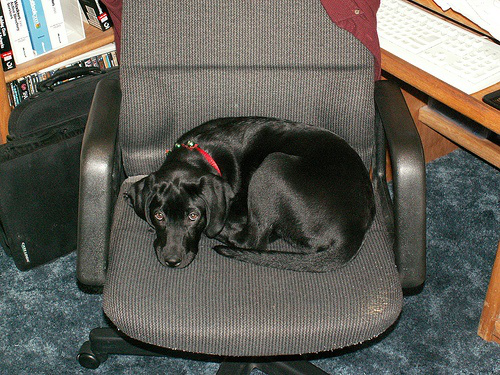

In [ ]:
import requests
from PIL import Image

url = "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg"
img = Image.open(requests.get(url, stream=True).raw)
display(img)

Second, load and intialize a pre-trained PyTorch model.

In [3]:
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Then apply the preprocessing transforms.

In [4]:
img = transforms.Compose([transforms.PILToTensor()])(img)
preprocess = weights.transforms()
batch = [preprocess(img)]

Then use the model for inference.

In [5]:
prediction = model(batch)[0]

Lastly, visualize the result.

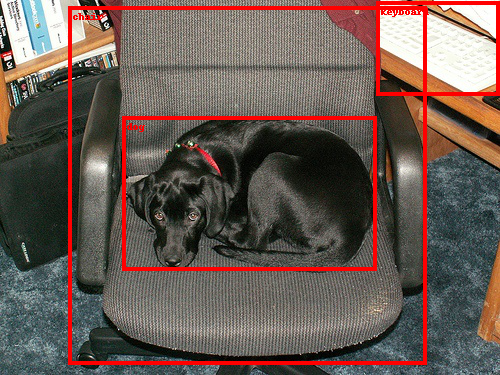

In [6]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img,
                          boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4)
im = to_pil_image(box.detach())
display(im)

## Scaling with Ray Data

Then let's see how to scale the previous example to a large set of images. We will use Ray Data to do batch inference in a streaming and distributed fashion, leveraging all the CPU and GPU resources in our cluster.

### Loading the Image Dataset

The dataset that we will be using is a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) that contains cats and dogs (the full dataset has 20 classes). There are 2434 images in the this dataset.

First, we use the {meth}`ray.data.read_images <ray.data.read_images>` API to load a prepared image dataset from S3. We can use the {meth}`schema <ray.data.Dataset.schema>` API to check the schema of the dataset. As we can see, it has one column named "image", and the value is the image data represented in `np.ndarray` format.

In [7]:
import ray

ds = ray.data.read_images("s3://anonymous@air-example-data/AnimalDetection/JPEGImages")
display(ds.schema())

[2023-05-19 18:10:29]  INFO ray._private.worker::Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
[2023-05-19 18:10:35] [Ray Data] WARNING ray.data.dataset::Important: Ray Data requires schemas for all datasets in Ray 2.5. This means that standalone Python objects are no longer supported. In addition, the default batch format is fixed to NumPy. To revert to legacy behavior temporarily, set the environment variable RAY_DATA_STRICT_MODE=0 on all cluster processes.

Learn more here: https://docs.ray.io/en/master/data/faq.html#migrating-to-strict-mode


Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

### Batch inference with Ray Data

As we can see from the PyTorch example, model inference consists of 2 steps: preprocessing the image and model inference. 

#### Preprocessing

First let's convert the preprocessing code to Ray Data. We'll package the preprocessing code within a `preprocess_image` function. This function should take only one argument, which is a dict that contains a single image in the dataset, represented as a numpy array.

In [8]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.detection import (FasterRCNN_ResNet50_FPN_V2_Weights,
                                          fasterrcnn_resnet50_fpn_v2)
from typing import Dict


def preprocess_image(data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    preprocessor = transforms.Compose(
        [transforms.ToTensor(), weights.transforms()]
    )
    return {
        "image": data["image"],
        "transformed": preprocessor(data["image"]),
    }

Then we use the {meth}`map <ray.data.Dataset.map>` API to apply the function to the whole dataset. By using Ray Data's map, we can scale out the preprocessing to all the resources in our Ray cluster. Note, the `map` method is lazy, it won't perform execution until we start to consume the results.

In [9]:
ds = ds.map(preprocess_image)

[2023-05-19 18:10:37] [Ray Data] WARNING ray.data.dataset::The `map`, `flat_map`, and `filter` operations are unvectorized and can be very slow. If you're using a vectorized transformation, consider using `.map_batches()` instead.


#### Model inference

Next, let's convert the model inference part. Compared with preprocessing, model inference has 2 differences:
1. Model loading and initialization is usually expensive. 
1. Model inference can be optimized with hardware acceleration if we process data in batches. Using larger batches improves GPU utilization and the overall runtime of the inference job.

Thus, we convert the model inference code to the following `ObjectDetectionModel` class. In this class, we put the expensive model loading and initialization code in the `__init__` constructor, which will run only once. And we put the model inference code in the `__call__` method, which will be called for each batch.

The `__call__` method takes a batch of data items, instead of a single one. In this case, the batch is also a dict that has one key named "image", and the value is an array of images represented in `np.ndarray` format. We can also use the {meth}`take_batch <ray.data.Dataset.take_batch>` API to fetch a single batch, and inspect its internal data structure.

In [10]:
single_batch = ds.take_batch(batch_size=3)
display(single_batch)

[2023-05-19 18:10:38] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map]
[2023-05-19 18:10:38] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
[2023-05-19 18:10:38] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

[2023-05-19 18:10:40] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Shutting down <StreamingExecutor(Thread-11, started daemon 16076255232)>.


{'image': array([array([[[173, 153, 142],
                [255, 246, 242],
                [255, 245, 245],
                ...,
                [255, 255, 244],
                [237, 235, 223],
                [214, 212, 200]],
 
               [[124, 105,  90],
                [255, 249, 238],
                [251, 244, 236],
                ...,
                [255, 252, 245],
                [255, 254, 247],
                [247, 244, 237]],
 
               [[ 56,  37,  20],
                [255, 253, 239],
                [248, 248, 236],
                ...,
                [248, 247, 243],
                [248, 247, 243],
                [254, 253, 249]],
 
               ...,
 
               [[ 64,  78,  87],
                [ 63,  74,  80],
                [105, 113, 115],
                ...,
                [ 94, 105, 109],
                [ 90,  99, 104],
                [ 84,  91,  97]],
 
               [[ 68,  86,  96],
                [ 69,  82,  88],
               

In [11]:
class ObjectDetectionModel:
    def __init__(self):
        # Define the model loading and initialization code in `__init__`.
        self.weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        self.model = fasterrcnn_resnet50_fpn_v2(
            weights=self.weights,
            box_score_thresh=0.9,
        )
        if torch.cuda.is_available():
            # Move the model to GPU if it's available.
            self.model = self.model.cuda()
        self.model.eval()

    def __call__(self, input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        # Define the per-batch inference code in `__call__`.
        batch = [torch.from_numpy(image) for image in input_batch["transformed"]]
        if torch.cuda.is_available():
            # Move the data to GPU if it's available.
            batch = [image.cuda() for image in batch]
        predictions = self.model(batch)
        return {
            "image": input_batch["image"],
            "labels": [pred["labels"].detach().cpu().numpy() for pred in predictions],
            "boxes": [pred["boxes"].detach().cpu().numpy() for pred in predictions],
        }

Then we use the {meth}`map_batches <ray.data.Dataset.map_batches>` API to apply the model to the whole dataset. 

The first parameter of `map` and `map_batches` is the user-defined function (UDF), which can either be a function or a class. Function-based UDFs run as short-running [Ray tasks](https://docs.ray.io/en/latest/ray-core/key-concepts.html#tasks), and class-based UDFs run as long-running [Ray actors](https://docs.ray.io/en/latest/ray-core/key-concepts.html#actors). For class-based UDFs, use the `concurrency` argument to specify the number of parallel actors. The `batch_size` argument indicates the number of images in each batch.

The `num_gpus` argument specifies the number of GPUs needed for each `ObjectDetectionModel` instance. The Ray scheduler can handle heterogeous resource requirements in order to maximize the resource utilization. In this case, the `ObjectDetectionModel` instances will run on GPU and `preprocess_image` instances will run on CPU.

In [12]:
ds = ds.map_batches(
    ObjectDetectionModel,
    # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    concurrency=4,
    batch_size=4,  # Use the largest batch size that can fit in GPU memory.
    # Specify 1 GPU per model replica. Remove this if you are doing CPU inference.
    num_gpus=1,
)

### Verify and Save Results

Then let's take a small batch and verify the inference results with visualization.

[2023-05-19 18:10:40] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->Map->MapBatches(ObjectDetectionModel)]
[2023-05-19 18:10:40] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
[2023-05-19 18:10:40] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
[2023-05-19 18:10:40] [Ray Data] INFO ray.data._internal.execution.operators.actor_pool_map_operator.logfile::ReadImage->Map->MapBatches(ObjectDetectionModel): Waiting for 4 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

[2023-05-19 18:11:50] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Shutting down <StreamingExecutor(Thread-26, started daemon 16076255232)>.
[2023-05-19 18:11:50] [Ray Data] WARNING ray.data._internal.execution.operators.actor_pool_map_operator.logfile::To ensure full parallelization across an actor pool of size 4, the specified batch size should be at most 3. Your configured batch size for this operator was 4.


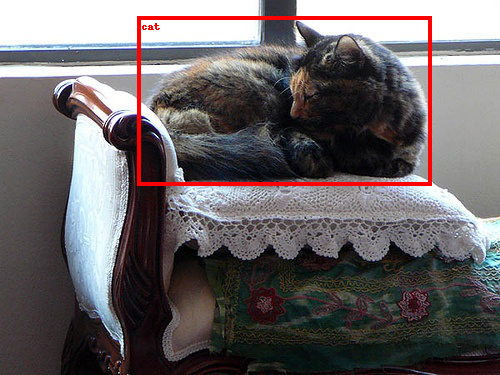

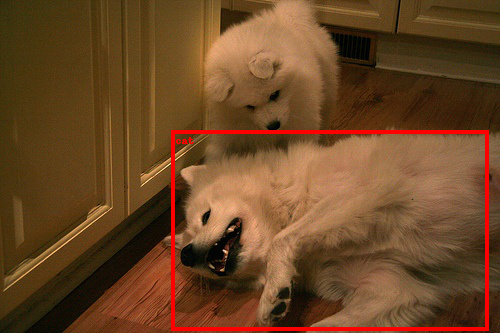

In [13]:
from torchvision.transforms.functional import convert_image_dtype, to_tensor

batch = ds.take_batch(batch_size=2)
for image, labels, boxes in zip(batch["image"], batch["labels"], batch["boxes"]):
    image = convert_image_dtype(to_tensor(image), torch.uint8)
    labels = [weights.meta["categories"][i] for i in labels]
    boxes = torch.from_numpy(boxes)
    img = to_pil_image(draw_bounding_boxes(
        image,
        boxes,
        labels=labels,
        colors="red",
        width=4,
    ))
    display(img)

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported stoarges and file formats.

```python
ds.write_parquet("local://tmp/inference_results")
```